# mixup: Beyond Empirical Risk Minimization
Хакер: Сибагатова Софья, БПМИ181


Поскольку статья про Mixup является относительно не новой, метод действительно рабочий, каким бы странным он не показался, то было решено провести эксперименты, связанные с тем, что произошло в области уже после появления Mixup.

In [1]:
#!g1.1
%pip install torch==1.9.1+cu111 torchvision==0.10.1+cu111 -f https://download.pytorch.org/whl/torch_stable.html

Defaulting to user installation because normal site-packages is not writeable
Looking in links: https://download.pytorch.org/whl/torch_stable.html
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.


In [2]:
#!g1.1
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import torch
import torch.nn as nn
import torchvision

from IPython.display import clear_output
from torch.autograd import Variable
from torchvision import datasets, models, transforms

In [3]:
#!g1.1
SEED = 3407

def set_seed(seed=SEED):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
set_seed()

In [4]:
#!g1.1
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [5]:
#!g1.1
results = pd.DataFrame(columns = ['train acc', 'test acc'])

## Experiment 1: Mixup, Cutout, CutMix

![cutmix](https://raw.githubusercontent.com/clovaai/CutMix-PyTorch/master/img1.PNG)

Mixup относят к нестандартным и продвинутым методам аугментации изображений, который несмотря на всю свою странность, действительно работает (как говорится, работает - не трогай). Однако существуют и другие виды аугментаций, которые можно отнести к нестандартным и продвинутым. Одним из таких методов является [Сutout](https://arxiv.org/pdf/1708.04552.pdf), появивишийся на ~год раньше Mixup и заключается просто в выбрасывании из изображении прямоугольного куска (его зануления). А через ~год после Mixup появился [CutMix](https://arxiv.org/pdf/1905.04899.pdf), который является чем-то средним между Cutout и Mixup: вместо зануления куска изображения происходит вставка другого изображения.

Посмотрим, как выглядят все три вида аугментации на наборе данных CIFAR10.


### CIFAR10

In [6]:
#!g1.1
MEAN, STD = (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)
CLASSES = np.array(['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])
NUM_CLASSES = len(CLASSES)

transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
])

trainset = datasets.CIFAR10(root='~/data', train=True, download=True,
                            transform=transform_train)

testset = datasets.CIFAR10(root='~/data', train=False, download=True,
                           transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
#!g1.1
BATCH_SIZE = 128
trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True, 
                                          num_workers=2)
testloader = torch.utils.data.DataLoader(testset, 
                                         batch_size=BATCH_SIZE,
                                         shuffle=False, 
                                         num_workers=2)

### Mixup

In [8]:
#!g1.1
def mixup_data(x, y, alpha=1.0, device=DEVICE):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

### Cutout


In [9]:
#!g1.1
import copy

def cutout_data(x, y, alpha=1.0, device=DEVICE):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    
    batch_size = x.size()[0]

    image_h, image_w = x.shape[2:]
    cx = np.random.uniform(0, image_w)
    cy = np.random.uniform(0, image_h)
    w = image_w * np.sqrt(1 - lam)
    h = image_h * np.sqrt(1 - lam)
    x0 = int(np.round(max(cx - w / 2, 0)))
    x1 = int(np.round(min(cx + w / 2, image_w)))
    y0 = int(np.round(max(cy - h / 2, 0)))
    y1 = int(np.round(min(cy + h / 2, image_h)))

    mixed_x = copy.deepcopy(x)
    mixed_x[:, :, y0:y1, x0:x1] = 0

    return mixed_x, y, None, lam

### CutMix

In [10]:
#!g1.1
def cutmix_data(x, y, alpha=1.0, device=DEVICE):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(device)
    shuffled_x = x[index]
    y_a, y_b = y, y[index]

    image_h, image_w = x.shape[2:]
    cx = np.random.uniform(0, image_w)
    cy = np.random.uniform(0, image_h)
    w = image_w * np.sqrt(1 - lam)
    h = image_h * np.sqrt(1 - lam)
    x0 = int(np.round(max(cx - w / 2, 0)))
    x1 = int(np.round(min(cx + w / 2, image_w)))
    y0 = int(np.round(max(cy - h / 2, 0)))
    y1 = int(np.round(min(cy + h / 2, image_h)))

    mixed_x = copy.deepcopy(x)
    mixed_x[:, :, y0:y1, x0:x1] = shuffled_x[:, :, y0:y1, x0:x1]

    return mixed_x, y_a, y_b, lam

### Visualization

In [11]:
#!g1.1
def plot_mixed_images(mixed_x, y_a, y_b, lam, title='Mixup', n=4):
    inv_normalize = transforms.Normalize(mean=[-m/s for m, s in zip(MEAN, STD)],
                                         std= [1/s for s in STD])
    inv_PIL = transforms.ToPILImage()
    fig = plt.figure(figsize=(2 * (n + 2), 4 + 2.5 * (n == 1)))
    plt.suptitle(title, fontsize='x-large')
    images, labels_a = mixed_x[:n], y_a[:n]
    if y_b is not None:
        labels_b = y_b[:n]
    for i in range(1, len(images) + 1):
        image = images[i-1]
        ax = fig.add_subplot(1, n, i)
        inv_tensor = inv_normalize(image).cpu()
        ax.imshow(inv_PIL(inv_tensor))
        if y_b is not None:
            ax.set_title(f'{lam:.2f} {CLASSES[labels_a[i-1]]}\n{1-lam:.2f} {CLASSES[labels_b[i-1]]}')
        else:
            ax.set_title(f'{CLASSES[labels_a[i-1]]}')
    plt.show()

In [12]:
#!g1.1
inputs, targets =  next(iter(trainloader))
inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

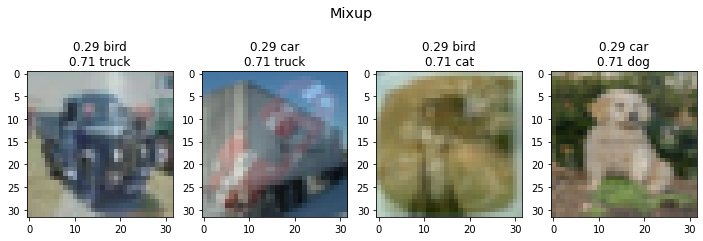

In [14]:
#!g1.1
plot_mixed_images(*mixup_data(inputs, targets))

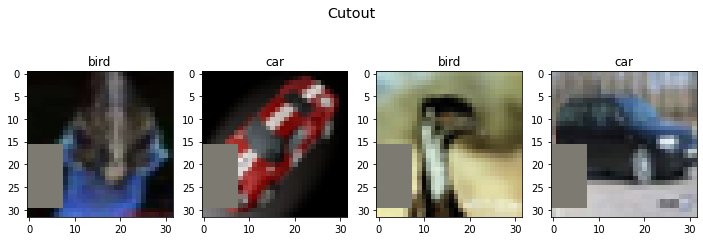

In [15]:
#!g1.1
plot_mixed_images(*cutout_data(inputs, targets), 'Cutout')

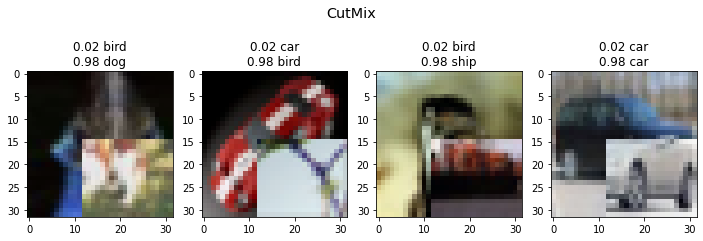

In [17]:
#!g1.1
plot_mixed_images(*cutmix_data(inputs, targets), 'CutMix')

Выглядит, конечно, интересно, но действительно ли можно хорошо обучить сеть с такими странными аугментациями?

Обычно, все три метода используются как вспомогательный прием при обучении моделей: на каждом шаге с какой-то вероятностью модель обучается как обычно, с какой-то - с помощью Mixup, Cutout или CutMix. Также данные методы обычно не используются изолированно, а применяются поверх стандартных (для тех или иных наборов данных) аугментаций. Считается, что Mixup показывает результаты лучше, чем Cutout, а CutMix, как своеобразная комбинация Cutout и Mixup, - лучше, чем Mixup.

Можно ли хорошо обучить модель, используя только данные методы, абсолютно не прибегая к обычному обучению? Иными словами, можно ли хорошо обучить модель, если мы будем показывать ей только "замиксованные" изображения, а исходную выборку на этапе обучения модель не увидит ни разу? "Справятся"  ли данные методы без стандартных аугментаций? Сохранится ли относительное положение методов по качеству при таком обучении?

Попробуем "поставить" все 3 метода в условия, описанные выше. Данный эксперимент заключается в обучении пяти моделей:

1. Модель без агументаций со стандартным обучением
2. Модель, обученная с Mixup
3. Модель, обученная с Cutout
4. Модель, обученная с CutMix
5. Модель со стандартными аугментациями (RandomHorizontalFlip() и RandomCrop(32, padding=4)) со стандартным обучением

**Уточнение:** Мы принимаем за данность (по результатам статей), что стандартные аугментации + Mixup/Cutout/CutMix лучше просто стандартных аугментаций + мы хотим посмотреть на результат работы методов в "тяжелых" условиях $\Rightarrow$ эксперименты вида "стандартные аугментации + Mixup/Cutout/CutMix" не проводятся.

Для каждой модели замеряется качество (accuracy) на обучающей и тестовой выборках. Ожидаем увидеть следующие результаты - по качеству на тестовой выборке имеет место следующее взаимное расположение моделей: 5 > 4 > 2 > 3 > 1

### Training loop

In [16]:
#!g1.1
def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

In [17]:
#!g1.1
def train(trainloader, model, criterion, optimizer, epoch, mix_type='mixup', alpha=1.0, device=DEVICE):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)

        if mix_type == 'mixup':
            inputs, targets_a, targets_b, lam = mixup_data(inputs, targets, alpha, device)
        
        elif mix_type == 'cutout':
            inputs, targets_a, targets_b, lam = cutout_data(inputs, targets, alpha, device)

        elif mix_type == 'cutmix':
            inputs, targets_a, targets_b, lam = cutmix_data(inputs, targets, alpha, device)

        elif mix_type is None:
            targets_a, targets_b = targets, None

        inputs, targets_a = map(Variable, (inputs, targets_a))
        if targets_b is not None:
            targets_b =  Variable(targets_b)

        outputs = model(inputs)

        if targets_b is not None:
            loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
        else:
            loss = criterion(outputs, targets_a)

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)

        if targets_b is not None:
            correct += (lam * predicted.eq(targets_a.data).cpu().sum().float() + \
                        (1 - lam) * predicted.eq(targets_b.data).cpu().sum().float())
        else:
            correct += predicted.eq(targets_a.data).cpu().sum().float()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return train_loss/batch_idx, 100.*correct/total

In [18]:
#!g1.1
def test(testloader, model, criterion, epoch, device=DEVICE):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(testloader):
        inputs, targets = inputs.to(device), targets.to(device)
        inputs, targets = map(Variable, (inputs, targets))
        with torch.no_grad():
            outputs = model(inputs)
        loss = criterion(outputs, targets)

        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()

    return test_loss/batch_idx, 100.*correct/total

In [19]:
#!g1.1
def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)
    plt.plot(val_history, c='orange', label='val', zorder=2)

    plt.xlabel('epochs')
    plt.legend(loc='best')
    plt.grid()

    plt.show()

In [20]:
#!g1.1
def train_loop(trainloader, testloader, model, criterion, optimizer, scheduler=None, mix_type='mixup', 
               alpha=1.0, num_epochs=200, best_model_path='best_model_mixup.pth', device=DEVICE):
    best_acc = 0 
    best_epoch = 0
    train_losses, train_accs = [], []
    test_losses, test_accs = [], []
    for epoch in range(num_epochs):
        train_loss, train_acc = train(trainloader, model, criterion, optimizer, epoch, mix_type, alpha, device)
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        test_loss, test_acc = test(testloader, model, criterion, epoch, device)
        test_losses.append(test_loss)
        test_accs.append(test_acc)

        clear_output()
        print(f'\nEpoch: {epoch + 1}/{num_epochs}')
        plot_history(train_losses, test_losses)    
        plot_history(train_accs, test_accs, title='accuracy') 
        print(f'Train Loss: {train_loss:.3f} | Acc: {train_acc:.3f}')  
        print(f'Test Loss: {test_loss:.3f} | Acc: {test_acc:.3f}')  

        if test_acc > best_acc:
            best_acc = test_acc
            best_epoch = epoch
            torch.save(model.state_dict(), best_model_path)
        if scheduler is not None:
            scheduler.step()
        elif mix_type == None:
            adjust_learning_rate(optimizer, epoch)
        if mix_type == 'mixup' or mix_type == 'cutmix':
            adjust_learning_rate(optimizer, epoch)
    print(f'Best accuracy: {best_acc:.3f}, best_epoch: {best_epoch}')
    return best_acc, best_epoch

In [21]:
#!g1.1
def adjust_learning_rate(optimizer, epoch):
    lr = 0.1
    if epoch >= 100:
        lr /= 10
    if epoch >= 150:
        lr /= 10
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [22]:
#!g1.1
class Identity(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x

In [23]:
#!g1.1
def get_model(device=DEVICE):
    model = models.resnet18()
    model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    model.maxpool = Identity()
    model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
    model.to(device)
    return model

In [24]:
#!g1.1
CRITERION = nn.CrossEntropyLoss()

### ResNet18 without augmentations

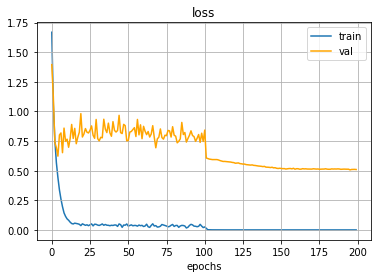

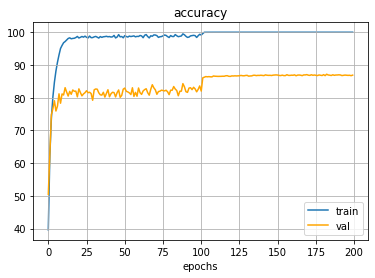


Epoch: 200/200
Train Loss: 0.000 | Acc: 100.000
Test Loss: 0.510 | Acc: 86.890
Best accuracy: 87.170, best_epoch: 182


In [25]:
#!g1.1
torch.cuda.empty_cache()
set_seed()

model = get_model()
optimizer = torch.optim.SGD(model.parameters(), 0.1, momentum=0.9, weight_decay=1e-4)
best_acc, best_epoch = train_loop(trainloader, testloader, model, CRITERION, optimizer, mix_type=None, best_model_path='best_model_no_aug.pth')
train_loss, train_acc = test(trainloader, model, CRITERION, best_epoch)
results.loc['ResNet18 without augmentations'] = [f'{train_acc:.3f}', f'{best_acc:.3f}']

### ResNet18 with Mixup

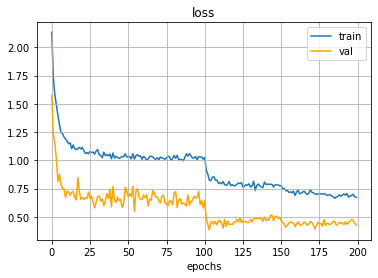

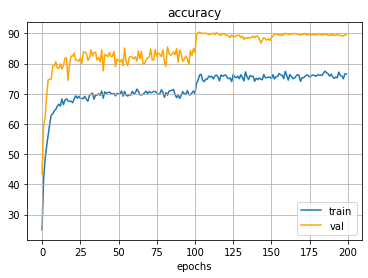


Epoch: 200/200
Train Loss: 0.673 | Acc: 76.546
Test Loss: 0.424 | Acc: 89.650
Best accuracy: 90.390, best_epoch: 103


In [26]:
#!g1.1
torch.cuda.empty_cache()
set_seed()

model = get_model()
optimizer = torch.optim.SGD(model.parameters(), 0.1, momentum=0.9, nesterov=True, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[60, 120, 160], gamma=0.2)
best_acc, best_epoch = train_loop(trainloader, testloader, model, CRITERION, optimizer, scheduler)
train_loss, train_acc = test(trainloader, model, CRITERION, best_epoch)
results.loc['ResNet18 with Mixup'] = [f'{train_acc:.3f}', f'{best_acc:.3f}']

### ResNet18 with Cutout

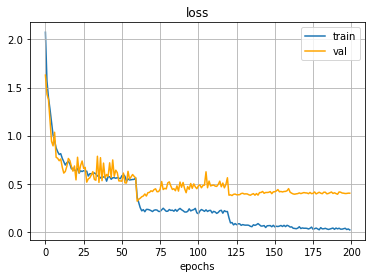

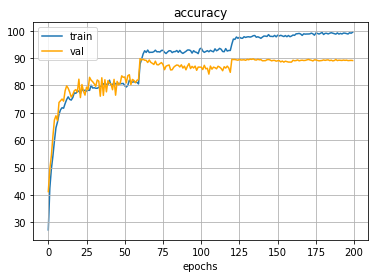


Epoch: 200/200
Train Loss: 0.020 | Acc: 99.450
Test Loss: 0.401 | Acc: 89.110
Best accuracy: 89.830, best_epoch: 60


In [32]:
#!g1.1
torch.cuda.empty_cache()
set_seed()

model = get_model()
optimizer = torch.optim.SGD(model.parameters(), 0.1, momentum=0.9, nesterov=True, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[60, 120, 160], gamma=0.2)
best_acc, best_epoch = train_loop(trainloader, testloader, model, CRITERION, optimizer, scheduler, 
                                  mix_type='cutout', best_model_path='best_model_cutout.pth')
train_loss, train_acc = test(trainloader, model, CRITERION, best_epoch)
results.loc['ResNet18 with Cutout'] = [f'{train_acc:.3f}', f'{best_acc:.3f}']

### ResNet18 with CutMix

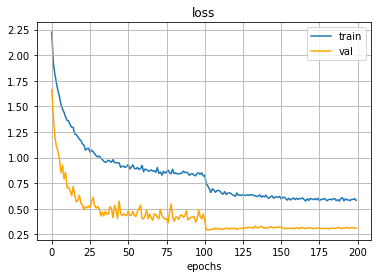

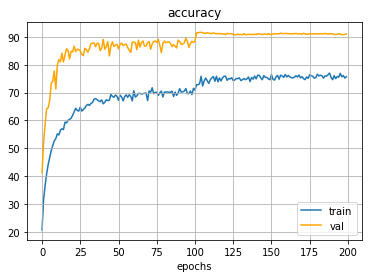


Epoch: 200/200
Train Loss: 0.583 | Acc: 75.651
Test Loss: 0.312 | Acc: 91.030
Best accuracy: 91.640, best_epoch: 104


In [28]:
#!g1.1
torch.cuda.empty_cache()
set_seed()

model = get_model()
optimizer = torch.optim.SGD(model.parameters(), 0.1, momentum=0.9, nesterov=True, weight_decay=1e-4)
best_acc, best_epoch = train_loop(trainloader, testloader, model, CRITERION, optimizer, 
                                  mix_type='cutmix', best_model_path='best_model_cutmix.pth')
train_loss, train_acc = test(trainloader, model, CRITERION, best_epoch)
results.loc['ResNet18 with CutMix'] = [f'{train_acc:.3f}', f'{best_acc:.3f}']

### ResNet18 with standard augmentations

In [29]:
#!g1.1
set_seed()

new_transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
])

new_trainset = datasets.CIFAR10(root='~/data', train=True, download=True,
                                transform=new_transform_train)

new_trainloader = torch.utils.data.DataLoader(new_trainset,
                                              batch_size=BATCH_SIZE,
                                              shuffle=True, 
                                              num_workers=2)

Files already downloaded and verified


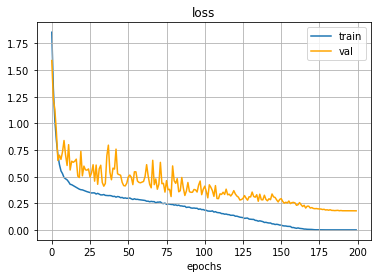

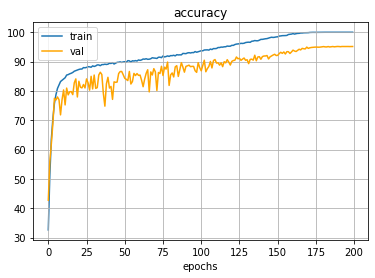


Epoch: 200/200
Train Loss: 0.002 | Acc: 99.994
Test Loss: 0.181 | Acc: 95.140
Best accuracy: 95.150, best_epoch: 189


In [30]:
#!g1.1
torch.cuda.empty_cache()
set_seed()

model = get_model()
optimizer = torch.optim.SGD(model.parameters(), 0.1, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
best_acc, best_epoch = train_loop(new_trainloader, testloader, model, CRITERION, optimizer, scheduler, 
                                  mix_type=None, best_model_path='best_model_aug.pth')
train_loss, train_acc = test(trainloader, model, CRITERION, best_epoch)
results.loc['ResNet18 with standard augmentations'] = [f'{train_acc:.3f}', f'{best_acc:.3f}']

### Results


In [87]:
#!g1.1
results

,train acc,test acc
ResNet18 without augmentations,100.000,87.170
ResNet18 with Mixup,99.946,90.390
ResNet18 with Cutout,100.000,89.830
ResNet18 with CutMix,99.998,91.640
ResNet18 with standard augmentations,100.000,95.150


Полученные результаты совпадают с ожидаемыми: standard augmentations > CutMix > Mixup > Cutout > no augmentations по качеству на тестовой выборке. Даже в "тяжелых" условиях странные на первый взгляд аугментации дают прирост по качеству по сравнению с моделью без каких-либо аугментаций, что действительно говорит о рабочести данных методов. 


## Experiment 2: Calibration


На текущий момент существует ряд статей ([статья 1](https://arxiv.org/pdf/1905.11001.pdf), [статья 2](https://arxiv.org/pdf/2102.06289.pdf)), которые утверждают, что модели, обученные с Mixup, лучше калиброваны. Проверим это, а также посмотрим на калиброванность моделей, обученных с Cutout и CutMix. Для каждой модели замеряются метрики ECE (Expected Calibration Error) и MCE (Maximum Calibration Error). Значение метрик, равное 0, означает идеальную калиброванность модели.


In [34]:
#!g1.1
results['ECE'], results['MCE'] = 0, 0

In [35]:
#!g1.1
def load_model(path='best_model_mixup.pth', device=DEVICE):
    model = get_model(device)
    model.load_state_dict(torch.load(path))
    return model

In [36]:
#!g1.1
def get_predictions(testloader, model, num_classes=NUM_CLASSES, device=DEVICE):
    model.eval()
    preds = []
    targets_ohe = []
    for batch_idx, (inputs, targets) in enumerate(testloader):
        inputs, targets = inputs.to(device), targets.to(device)
        inputs, targets = Variable(inputs), Variable(targets)
        with torch.no_grad():
            outputs = model(inputs)

        # get probabilities
        pred = nn.Softmax(1)(outputs)
        pred = pred.cpu().detach().numpy()

        # Convert targets to one hot encoding
        target_ohe = torch.nn.functional.one_hot(targets, num_classes=num_classes)
        target_ohe = target_ohe.cpu().detach().numpy()

        preds.extend(pred)
        targets_ohe.extend(target_ohe)

    preds = np.array(preds).flatten()
    targets_ohe = np.array(targets_ohe).flatten()
    
    return preds, targets_ohe

In [37]:
#!g1.1
def calc_bins(preds, targets_ohe, num_bins=10):
    bins = np.linspace(0.1, 1, num_bins)
    binned = np.digitize(preds, bins)

    bin_accs = np.zeros(num_bins)
    bin_confs = np.zeros(num_bins)
    bin_sizes = np.zeros(num_bins)

    for bin in range(num_bins):
        bin_sizes[bin] = len(preds[binned == bin])
        if bin_sizes[bin] > 0:
            bin_accs[bin] = (targets_ohe[binned==bin]).sum() / bin_sizes[bin]
            bin_confs[bin] = (preds[binned==bin]).sum() / bin_sizes[bin]

    return bins, binned, bin_accs, bin_confs, bin_sizes

In [38]:
#!g1.1
def get_metrics(preds, targets_ohe, num_bins=10):
    ECE = 0
    MCE = 0
    bins, _, bin_accs, bin_confs, bin_sizes = calc_bins(preds, targets_ohe, num_bins)

    for i in range(len(bins)):
        abs_conf_dif = abs(bin_accs[i] - bin_confs[i])
        ECE += (bin_sizes[i] / sum(bin_sizes)) * abs_conf_dif
        MCE = max(MCE, abs_conf_dif)

    return ECE, MCE

In [39]:
#!g1.1
import matplotlib.patches as mpatches

def draw_reliability_graph(preds, targets_ohe, num_bins=10, title='ResNet18 with Mixup'):
    ECE, MCE = get_metrics(preds, targets_ohe, num_bins)
    bins, _, bin_accs, _, _ = calc_bins(preds, targets_ohe, num_bins)

    fig = plt.figure(figsize=(8, 8))
    ax = fig.gca()

    ax.set_xlim(0, 1.05)
    ax.set_ylim(0, 1)

    plt.xlabel('Confidence')
    plt.ylabel('Accuracy')
    
    plt.title(title+' calibration')

    ax.set_axisbelow(True) 
    ax.grid(color='gray', linestyle='dashed')

    plt.bar(bins, bins,  width=0.1, alpha=0.3, edgecolor='black', color='r', hatch='\\')

    plt.bar(bins, bin_accs, width=0.1, alpha=1, edgecolor='black', color='b')
    plt.plot([0,1],[0,1], '--', color='gray', linewidth=2)

    plt.gca().set_aspect('equal', adjustable='box')

    ECE_patch = mpatches.Patch(color='green', label='ECE = {:.2f}%'.format(ECE*100))
    MCE_patch = mpatches.Patch(color='red', label='MCE = {:.2f}%'.format(MCE*100))
    plt.legend(handles=[ECE_patch, MCE_patch])

    plt.show()
    
    return ECE*100, MCE*100

### ResNet18 without augmentations


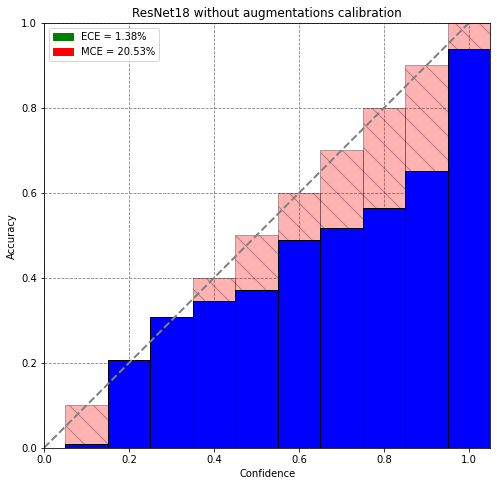

In [40]:
#!g1.1
no_aug_model = load_model('best_model_no_aug.pth')
preds, targets_ohe = get_predictions(testloader, no_aug_model)
ECE, MCE = draw_reliability_graph(preds, targets_ohe, title='ResNet18 without augmentations')
results.loc['ResNet18 without augmentations', ['ECE', 'MCE']] = f'{ECE:.2f}', f'{MCE:.2f}'

### ResNet18 with Mixup


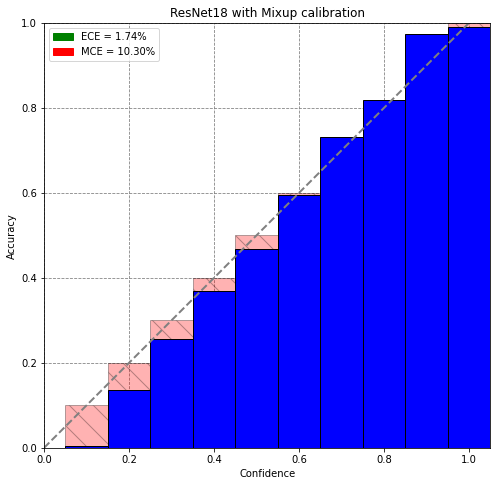

In [41]:
#!g1.1
mixup_model = load_model()
preds, targets_ohe = get_predictions(testloader, mixup_model)
ECE, MCE = draw_reliability_graph(preds, targets_ohe)
results.loc['ResNet18 with Mixup', ['ECE', 'MCE']] = f'{ECE:.2f}', f'{MCE:.2f}'

### ResNet18 with Cutout

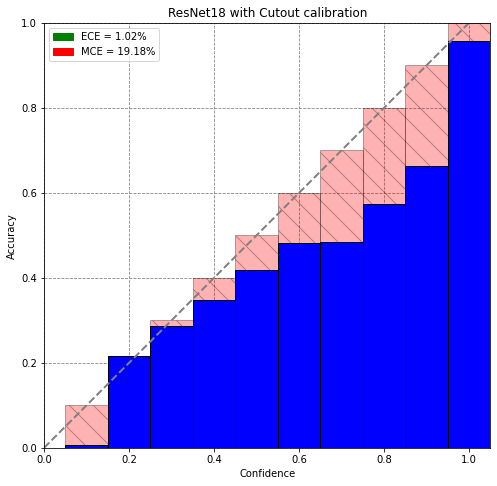

In [42]:
#!g1.1
cutout_model = load_model('best_model_cutout.pth')
preds, targets_ohe = get_predictions(testloader, cutout_model)
ECE, MCE = draw_reliability_graph(preds, targets_ohe, title='ResNet18 with Cutout')
results.loc['ResNet18 with Cutout', ['ECE', 'MCE']] = f'{ECE:.2f}', f'{MCE:.2f}'

### ResNet18 with CutMix

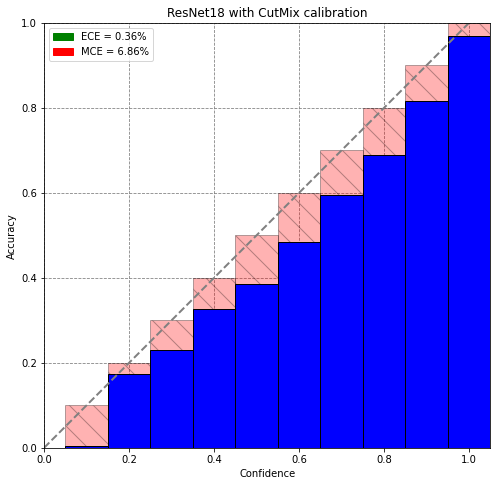

In [43]:
#!g1.1
cutmix_model = load_model('best_model_cutmix.pth')
preds, targets_ohe = get_predictions(testloader, cutmix_model)
ECE, MCE = draw_reliability_graph(preds, targets_ohe, title='ResNet18 with CutMix')
results.loc['ResNet18 with CutMix', ['ECE', 'MCE']] = f'{ECE:.2f}', f'{MCE:.2f}'

### ResNet18 with standard augmentations


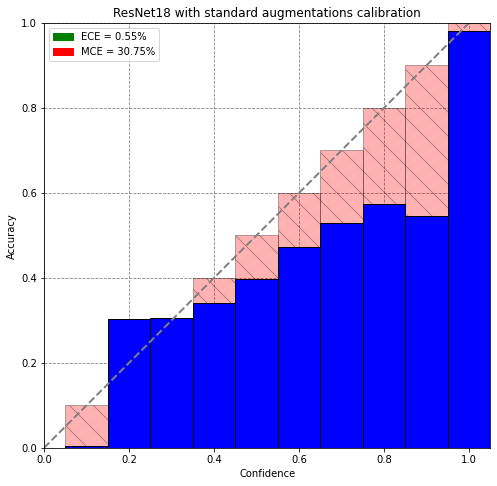

In [44]:
#!g1.1
aug_model = load_model('best_model_aug.pth')
preds, targets_ohe = get_predictions(testloader, aug_model)
ECE, MCE = draw_reliability_graph(preds, targets_ohe, title='ResNet18 with standard augmentations')
results.loc['ResNet18 with standard augmentations', ['ECE', 'MCE']] = f'{ECE:.2f}', f'{MCE:.2f}'

### Results


In [88]:
#!g1.1
results

,train acc,test acc,ECE,MCE
ResNet18 without augmentations,100.000,87.170,1.38,20.53
ResNet18 with Mixup,99.946,90.390,1.74,10.30
ResNet18 with Cutout,100.000,89.830,1.02,19.18
ResNet18 with CutMix,99.998,91.640,0.36,6.86
ResNet18 with standard augmentations,100.000,95.150,0.55,30.75


Получили достаточно интересный результат: по метрике MCE модели, обученные стандартным методом, хуже калиброваны, чем модели, обученные с Mixup, Cutout или CutMix. Причем по метрике MCE также сохраняется отношение CutMix > Mixup > Cutout. Модель с CutMix является самой калиброванной, что неудивительно, поскольку, как было сказано уже несколько раз, CutMix является комбинацией Mixup и Cutout и, можно сказать, "взял только самое лучшее от своих родителей". А вот метрика ECE не отражает действительности: модель с Mixup является самой плохо-калиброванной моделью по метрике ECE. Данный результат может быть связан с использованием параметра $\alpha = 1.0$ (параметр распределения $Beta(\alpha, \alpha)$, из которого выбирается параметр смешивания в Mixup), вследствие чего ниже будет проведен эксперимент по сравнению калиброванности моделей с Mixup с различными параметрами $\alpha$.


## Experiment 3: CAM visualization


Данный эксперимент сложно назвать экспериментом. Скорее данный пункт показывает симпатичные визуализации работы моделей, обученных с Mixup, Cutout или CutMix, а именно представлены тепловые карты, показывающие, куда именно смотрит на входном "замиксованном" изображении та или иная модель для построения предсказания.


In [46]:
#!g1.1
%pip install torchcam

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.


In [47]:
#!g1.1
from torchcam.methods import CAM
from torchcam.utils import overlay_mask
from torchvision.transforms.functional import to_pil_image

In [48]:
#!g1.1
inv_normalize = transforms.Normalize(mean=[-m/s for m, s in zip(MEAN, STD)],
                                     std= [1/s for s in STD])

In [49]:
#!g1.1
def draw_activation_map(extractor, model, image, label_a, label_b, title='Mixup'):
    input_tensor = Variable(image)
    out = model(input_tensor)
    
    activation_map_1 = extractor(label_a.item(), out)
    result_1 = overlay_mask(to_pil_image(inv_normalize(image[0])), to_pil_image(activation_map_1[0], mode='F'), alpha=0.5)
    
    if label_b is not None:
        activation_map_2 = extractor(label_b.item(), out)
        result_2 = overlay_mask(to_pil_image(inv_normalize(image[0])), to_pil_image(activation_map_2[0], mode='F'), alpha=0.5)
    
        fig = plt.figure(figsize=(10, 5))
        plt.suptitle(title, fontsize='x-large')

        ax = fig.add_subplot(1, 2, 1)
        ax.imshow(result_1)
        ax.set_title(f'{CLASSES[label_a.item()]}')

        ax = fig.add_subplot(1, 2, 2)
        ax.imshow(result_2)
        ax.set_title(f'{CLASSES[label_b.item()]}')
    else:
        fig = plt.figure(figsize=(5, 5))
        plt.imshow(result_1)
        plt.title(title+f'\n{CLASSES[label_a.item()]}', fontsize='x-large')
            
    plt.show()

### ResNet18 with Mixup

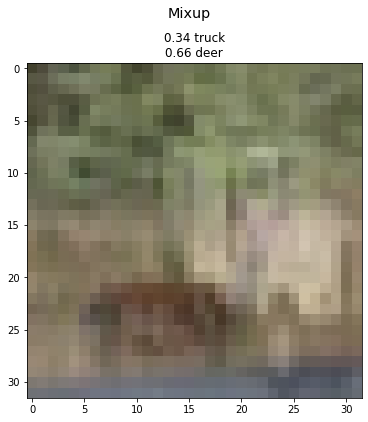

In [49]:
#!g1.1
inputs, targets =  next(iter(trainloader))
inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
mixed_x, y_a, y_b, lam = mixup_data(inputs, targets)
plot_mixed_images(mixed_x, y_a, y_b, lam, n=1)
image, label_a, label_b = mixed_x[:1], y_a[:1], y_b[:1]

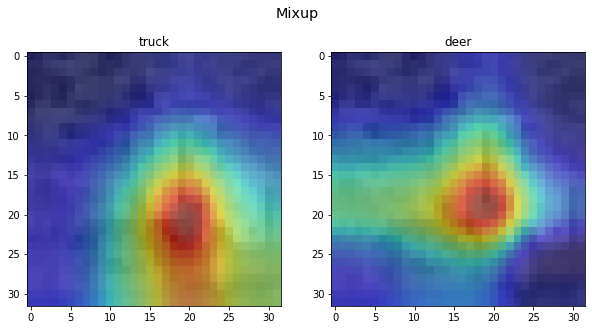

In [50]:
#!g1.1
mixup_model = load_model().eval()
cam_extractor = CAM(mixup_model)
draw_activation_map(cam_extractor, mixup_model, image, label_a, label_b)

### ResNet18 with Cutout


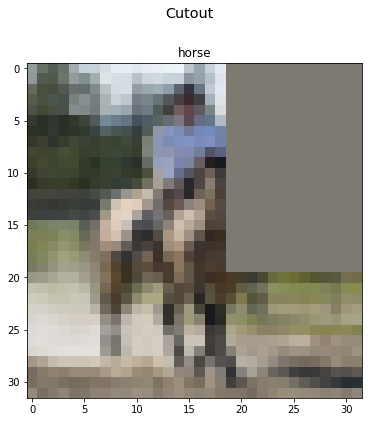

In [70]:
#!g1.1
inputs, targets =  next(iter(trainloader))
inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
mixed_x, y_a, y_b, lam = cutout_data(inputs, targets)
plot_mixed_images(mixed_x, y_a, y_b, lam, 'Cutout', n=1)
image, label_a, label_b = mixed_x[:1], y_a[:1], y_b

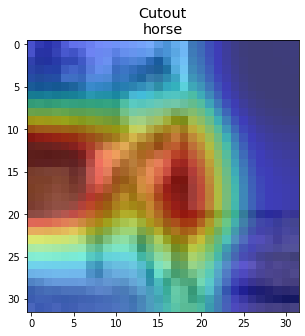

In [71]:
#!g1.1
cutout_model = load_model('best_model_cutout.pth').eval()
cam_extractor = CAM(cutout_model)
draw_activation_map(cam_extractor, cutout_model, image, label_a, label_b, 'Cutout')

### ResNet18 with CutMix


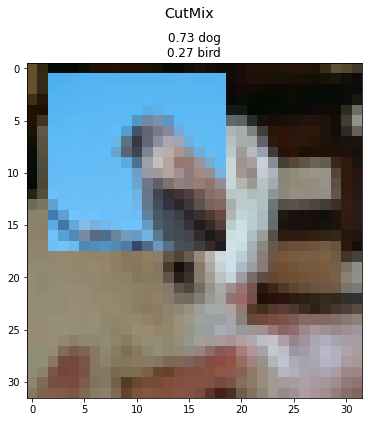

In [128]:
#!g1.1
inputs, targets =  next(iter(trainloader))
inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
mixed_x, y_a, y_b, lam = cutmix_data(inputs, targets)
plot_mixed_images(mixed_x, y_a, y_b, lam, 'CutMix', n=1)
image, label_a, label_b = mixed_x[:1], y_a[:1], y_b[:1]

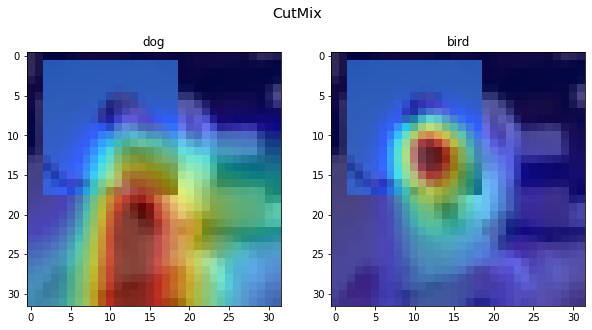

In [129]:
#!g1.1
cutmix_model = load_model('best_model_cutmix.pth').eval()
cam_extractor = CAM(cutmix_model)
draw_activation_map(cam_extractor, cutmix_model, image, label_a, label_b, 'CutMix')

## Experiment 4: all experiments for Mixup with different alpha


Как уже было сказано ранее, модель с Mixup и параметром $\alpha = 1.0$ получилась так себе калиброванной, что натолкнуло на мысль о зависимости калиброванности модели от $\alpha$. В данном эксперименте были обучены еще 2 модели с Mixup с параметрами $\alpha = 0.5$ и $\alpha = 0.2$ и проведены эксперименты, аналогичные экспериментам 1, 2, 3.


### Training


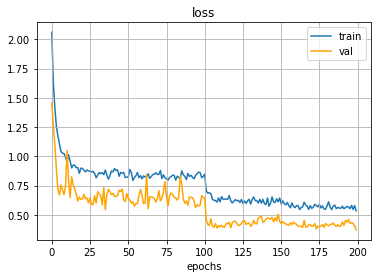

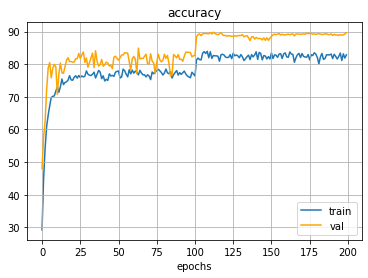


Epoch: 200/200
Train Loss: 0.536 | Acc: 82.876
Test Loss: 0.372 | Acc: 89.620
Best accuracy: 89.790, best_epoch: 112


In [72]:
#!g1.1
torch.cuda.empty_cache()
set_seed()

model = get_model()
optimizer = torch.optim.SGD(model.parameters(), 0.1, momentum=0.9, nesterov=True, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[60, 120, 160], gamma=0.2)
best_acc, best_epoch = train_loop(trainloader, testloader, model, CRITERION, optimizer, scheduler, 
                                  alpha=0.5, best_model_path='best_model_mixup05.pth')
train_loss, train_acc = test(trainloader, model, CRITERION, best_epoch)
results.loc['ResNet18 with Mixup, alpha=0.5', ['train acc', 'test acc']] = f'{train_acc:.3f}', f'{best_acc:.3f}'

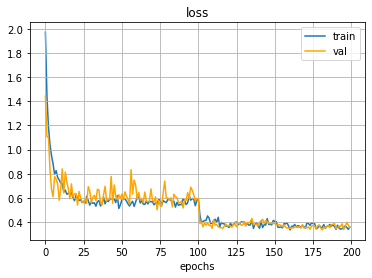

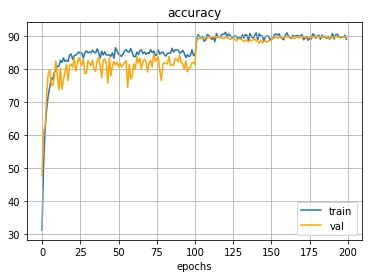


Epoch: 200/200
Train Loss: 0.360 | Acc: 89.118
Test Loss: 0.356 | Acc: 90.010
Best accuracy: 90.070, best_epoch: 181


In [73]:
#!g1.1
torch.cuda.empty_cache()
set_seed()

model = get_model()
optimizer = torch.optim.SGD(model.parameters(), 0.1, momentum=0.9, nesterov=True, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[60, 120, 160], gamma=0.2)
best_acc, best_epoch = train_loop(trainloader, testloader, model, CRITERION, optimizer, scheduler, 
                                  alpha=0.2, best_model_path='best_model_mixup02.pth')
train_loss, train_acc = test(trainloader, model, CRITERION, best_epoch)
results.loc['ResNet18 with Mixup, alpha=0.2', ['train acc', 'test acc']] = f'{train_acc:.3f}', f'{best_acc:.3f}'

### Calibration


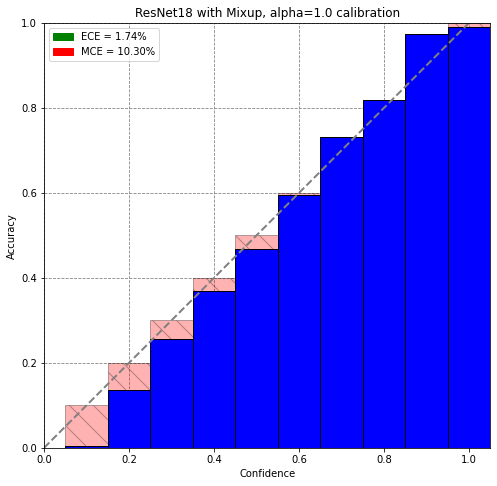

In [132]:
#!g1.1
mixup_model = load_model('best_model_mixup.pth')
preds, targets_ohe = get_predictions(testloader, mixup_model)
ECE, MCE = draw_reliability_graph(preds, targets_ohe, title='ResNet18 with Mixup, alpha=1.0')

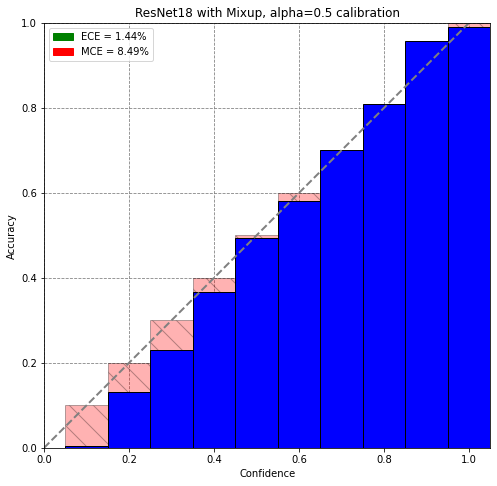

In [74]:
#!g1.1
mixup05_model = load_model('best_model_mixup05.pth')
preds, targets_ohe = get_predictions(testloader, mixup05_model)
ECE, MCE = draw_reliability_graph(preds, targets_ohe, title='ResNet18 with Mixup, alpha=0.5')
results.loc['ResNet18 with Mixup, alpha=0.5', ['ECE', 'MCE']] = f'{ECE:.2f}', f'{MCE:.2f}'

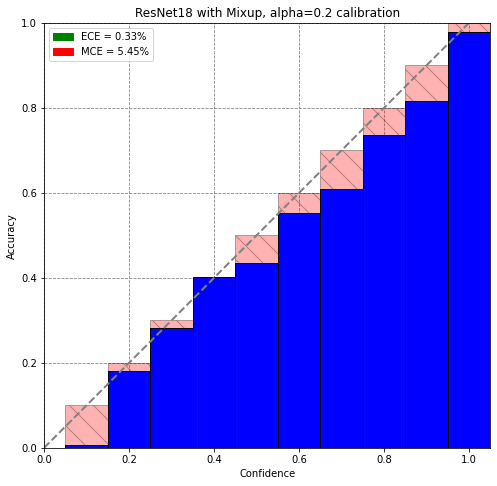

In [75]:
#!g1.1
mixup02_model = load_model('best_model_mixup02.pth')
preds, targets_ohe = get_predictions(testloader, mixup02_model)
ECE, MCE = draw_reliability_graph(preds, targets_ohe, title='ResNet18 with Mixup, alpha=0.2')
results.loc['ResNet18 with Mixup, alpha=0.2', ['ECE', 'MCE']] = f'{ECE:.2f}', f'{MCE:.2f}'

### Results


In [89]:
#!g1.1
results

,train acc,test acc,ECE,MCE
ResNet18 without augmentations,100.000,87.170,1.38,20.53
ResNet18 with Mixup,99.946,90.390,1.74,10.30
ResNet18 with Cutout,100.000,89.830,1.02,19.18
ResNet18 with CutMix,99.998,91.640,0.36,6.86
ResNet18 with standard augmentations,100.000,95.150,0.55,30.75
"ResNet18 with Mixup, alpha=0.5",99.998,89.790,1.44,8.49
"ResNet18 with Mixup, alpha=0.2",100.000,90.070,0.33,5.45


Качество всех моделей Mixup +- одинаковое и сохраняет тот же относительный порядок CutMix > Mixup > Cutout. Однако наиболее интересным результатом является то, что теперь самой калиброванной моделью являтся Mixup с $\alpha = 0.2$ по обоим метрикам. Заметим, что параметр $\alpha$ по сути отвечает за "степень миксованности" изображений, то есть для параметра $\alpha = 1.0$ мы получаем более сильные аугментации, чем для параметра $\alpha = 0.2$. Данное утверждение подтверждается качеством на обучающей выборке: имеет место отношение $\alpha = 0.2$ > $\alpha = 0.5$ > $\alpha = 1.0$. Таким образом, Mixup действительно улучшает калиброванность модели, но при слишком сильном "миксовании" изображений данный эффект становится хуже.


### CAM visualization


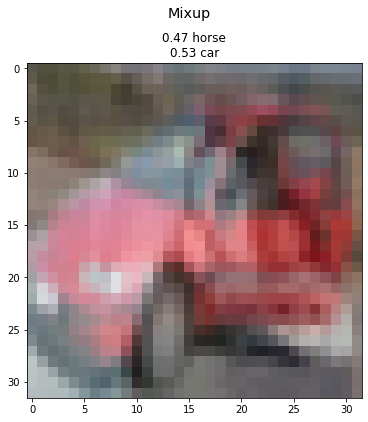

In [170]:
#!g1.1
inputs, targets =  next(iter(trainloader))
inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
mixed_x, y_a, y_b, lam = mixup_data(inputs, targets)
plot_mixed_images(mixed_x, y_a, y_b, lam, n=1)
image, label_a, label_b = mixed_x[:1], y_a[:1], y_b[:1]

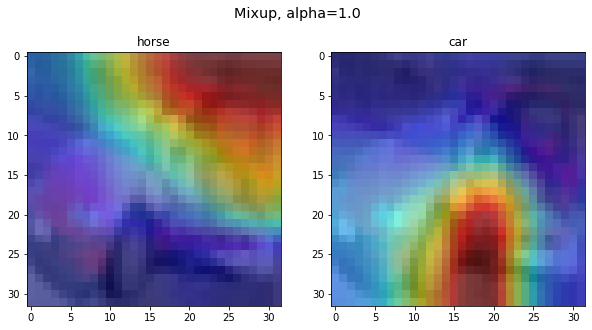

In [171]:
#!g1.1
mixup_model = load_model('best_model_mixup.pth').eval()
cam_extractor = CAM(mixup_model)
draw_activation_map(cam_extractor, mixup_model, image, label_a, label_b, 'Mixup, alpha=1.0')

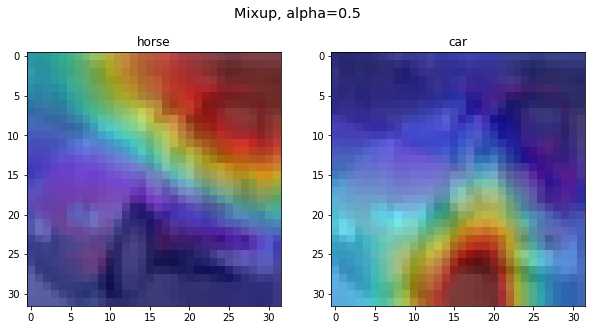

In [172]:
#!g1.1
mixup05_model = load_model('best_model_mixup05.pth').eval()
cam_extractor = CAM(mixup05_model)
draw_activation_map(cam_extractor, mixup05_model, image, label_a, label_b, 'Mixup, alpha=0.5')

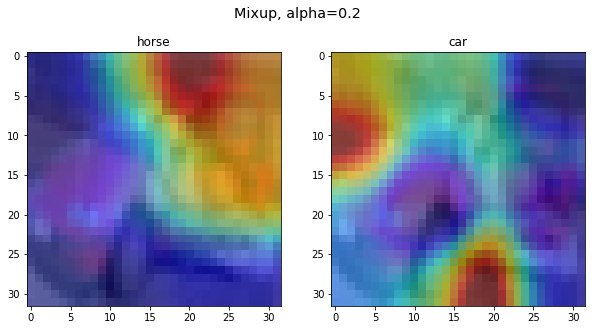

In [173]:
#!g1.1
mixup02_model = load_model('best_model_mixup02.pth').eval()
cam_extractor = CAM(mixup02_model)
draw_activation_map(cam_extractor, mixup02_model, image, label_a, label_b, 'Mixup, alpha=0.2')